## Importar librerías

In [919]:
import pandas as pd
from nltk.corpus import stopwords
import seaborn as sns
import numpy as np
import spacy 
from sklearn.feature_extraction.text import CountVectorizer
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier
import networkx as nx

## Data Cleanning

In [920]:
friends = pd.read_csv("friends_quotes.csv")

In [921]:
friends.drop(friends[(friends["season"] == 1) & (friends["episode_number"] == 16)].index,inplace = True)

In [922]:
chandler =["CHAN","CHANDLER","Chandler (Stands up and walks to Joey)","Chandle","Chandler (nearly weeping)","Chandler (to Joey)", "Chandler (to Monica)", "Chandlers"]
monica =["Young Monica","Fake Monica", "Fat Monica", "MONICA","MNCA","MOnica","Monic","Monica (to Ross)","Monica about to have a heart attack","Monica to Amy","Monica to Emma","Monica to Ross","Monica (reads a form in her lap)"] 
joey = ["Fat Joey","JOEY","Joe","Joey (staring at the cake)","Joey (to Rachel)","Joey (to Ross)"]
phoebe = ["PHOE","PHOEBE","Phoeb","Phoebe (to Mike)","Phoebe (to Rachel)","Phoebe (walking to Ross carrying a black leather jacket)","Phoebe (watching the food on the table)","Phoebe looks down"]
rachel = ["RACH","RACHEL","RAHCEL", "Rache","Rachel (crying)","Rachel (leaving)","Rachel (on the phone)","Rachel (she flips the coin)","Rachel opens their door","Rachel to Emma","Rachel (as Monica)","Racel"]
ross = ["ROSS","Ross (on the verge of tears)","Ross (stops recording)","Ross (to Emma)","Ross first has a look of 'huh' then changes it to sarcastic happy","Ross looks down","Ross makes some sort of sound to let us know it hurt","Ross starts playing with a plate","Ross starts talking over her 'do you remember' line","Ross to Monica","Ross with a look of wondering how long this is going to go on on his face","Young Ross","ros"]

In [923]:
friends["author"] = friends["author"].apply(lambda x: "Chandler" if x in chandler else x).apply(lambda x: "Phoebe" if x in phoebe else x).apply(lambda x: "Joey" if x in joey else x).apply(lambda x: "Rachel" if x in rachel else x).apply(lambda x: "Ross" if x in ross else x).apply(lambda x: "Monica" if x in monica else x).str.strip().str.lower().str.replace("ms. geller","mrs. geller").str.capitalize()

In [924]:
friends["author"].value_counts().head(13)

Rachel      9107
Ross        8932
Monica      8322
Chandler    8268
Joey        8022
Phoebe      7346
Mike         351
All          330
Richard      256
Janice       214
Charlie      190
Carol        187
Emily        160
Name: author, dtype: int64

In [925]:
more_common_characters = friends["author"].value_counts().head(13).index.to_list()

In [926]:
friends[friends["author"]=="Mike"]["season"].value_counts()# we need to delete the mikes from season 3 and 4  

9.0     229
10.0    115
4.0       4
3.0       3
Name: season, dtype: int64

In [927]:
friends[friends["author"]=="Richard"]["season"].value_counts() # we need to delete the Richard from season 7

2.0    128
6.0     50
3.0     43
7.0     35
Name: season, dtype: int64

In [928]:
more_common_characters.remove("All")

In [929]:
friends.drop(friends[(friends["author"] == "Mike") & (friends["season"].isin(["3.0","4.0"]))].index,inplace = True)

In [930]:
friends[friends["author"]=="Mike"]["season"].value_counts()

9.0     229
10.0    115
Name: season, dtype: int64

In [931]:
friends.drop(friends[(friends["author"] == "Richard") & (friends["season"].isin(["7.0"]))].index,inplace = True)

In [932]:
friends[friends["author"]=="Richard"]["season"].value_counts()

2.0    128
6.0     50
3.0     43
Name: season, dtype: int64

In [933]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15,9)

<AxesSubplot:xlabel='count', ylabel='author'>

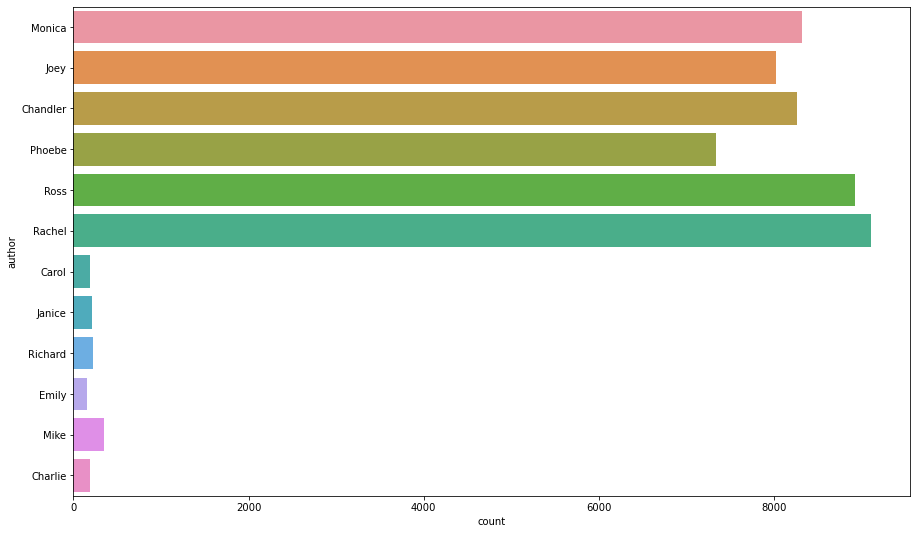

In [934]:
sns.countplot(y='author', data=friends[friends.author.isin(more_common_characters)])

In [935]:
new_df = friends[friends["author"].isin(more_common_characters)]
new_df

,author,episode_number,episode_title,quote,quote_order,season
0,Monica,1.0,Monica Gets A Roommate,There's nothing to tell! He's just some guy I ...,0.0,1.0
1,Joey,1.0,Monica Gets A Roommate,"C'mon, you're going out with the guy! There's ...",1.0,1.0
2,Chandler,1.0,Monica Gets A Roommate,"All right Joey, be nice. So does he have a hum...",2.0,1.0
3,Phoebe,1.0,Monica Gets A Roommate,"Wait, does he eat chalk?",3.0,1.0
4,Phoebe,1.0,Monica Gets A Roommate,"Just, 'cause, I don't want her to go through w...",4.0,1.0
...,...,...,...,...,...,...
60286,Chandler,17.0,"The Last One, Part I & II","Oh, it's gonna be okay.",581.0,10.0
60287,Rachel,17.0,"The Last One, Part I & II",(crying) Do you guys have to go to the new hou...,582.0,10.0
60288,Monica,17.0,"The Last One, Part I & II",We got some time.,583.0,10.0
60289,Rachel,17.0,"The Last One, Part I & II","Okay, should we get some coffee?",584.0,10.0


In [936]:
new_df.to_excel(r"./all.xlsx", index = False)

In [937]:
episode1_24 = pd.read_excel("all_modified.xlsx")

In [938]:
main_characters = ["Ross", "Joey","Chandler","Phoebe","Rachel","Monica"]

In [939]:
episode1_24= episode1_24.drop(columns=['episode_number', 'episode_title', "quote_order"]).reset_index(drop = True)
episode1_24

,author,quote,season,To Whom,Conversation
0,Monica,There's nothing to tell! He's just some guy I ...,1,All,All
1,Joey,"C'mon, you're going out with the guy! There's ...",1,All,All
2,Chandler,"All right Joey, be nice. So does he have a hum...",1,All,All
3,Phoebe,"Wait, does he eat chalk?",1,All,All
4,Phoebe,"Just, 'cause, I don't want her to go through w...",1,All,All
...,...,...,...,...,...
3778,Joey,Seven hundred bucks!,1,Chandler,"Chandler, Joey"
3779,Chandler,"Alright, you did it! Do we have any fruit?",1,Joey,"Chandler, Joey"
3780,Joey,"Man, hell of a two weeks, huh? Y'know what, th...",1,Chandler,"Chandler, Joey"
3781,Chandler,"Really? So, you're gonna stick with this 'it's...",1,Joey,"Chandler, Joey"


In [940]:
episode1_24["quote"] = episode1_24["quote"].str.replace("\(([^)]+)\)","").str.strip().str.lower().str.split("[.|!|?]", expand = False)
episode1_24["quote"]

0       [there's nothing to tell,  he's just some guy ...
1       [c'mon, you're going out with the guy,  there'...
2       [all right joey, be nice,  so does he have a h...
3                             [wait, does he eat chalk, ]
4       [just, 'cause, i don't want her to go through ...
                              ...                        
3778                              [seven hundred bucks, ]
3779       [alright, you did it,  do we have any fruit, ]
3780    [man, hell of a two weeks, huh,  y'know what, ...
3781    [really,  so, you're gonna stick with this 'it...
3782    [what, are you crazy,  when a blind man gets h...
Name: quote, Length: 3783, dtype: object

In [941]:
episode1_24 = episode1_24.explode("quote")

In [942]:
episode1_24.reset_index(drop = True, inplace = True)

In [943]:
scene = episode1_24[episode1_24["quote"].str.contains("scene:")].index.to_list()
scene

[150, 410]

In [944]:
episode1_24 = episode1_24.drop(episode1_24.index[scene])

In [945]:
episode1_24["quote"] = episode1_24["quote"].str.replace("[^a-zA-Z' ]","")

In [946]:
episode1_24.reset_index(drop = True, inplace = True)

In [947]:
indexes = []
for i in range(len(episode1_24["quote"])):
    if len(episode1_24["quote"][i]) == 0:
        indexes.append(i)

In [948]:
episode1_24 = episode1_24.drop(episode1_24.index[indexes]).reset_index(drop = True)

In [949]:
episode1_24["quote"] = episode1_24["quote"].str.strip()

In [950]:
episode1_24['number_words'] = episode1_24['quote'].str.count(' ') + 1

In [951]:
one_word = episode1_24[episode1_24["number_words"] == 1].index.to_list()

In [952]:
episode1_24 = episode1_24.drop(episode1_24.index[one_word]).reset_index(drop = True)

In [953]:
episode1_24["quote"] = episode1_24["quote"].str.replace("'\s","")

In [954]:
episode1_24["quote"] = episode1_24["quote"].str.replace("'cause","because").str.replace("you know","y'know").str.replace("you are","you're").str.replace("come on","c'mon").str.replace("'kay","okay").str.replace("'em","them").str.replace("doin'","doing").str.replace("(ya)","you").str.replace("lemme","let me").str.replace("gonna", "going to").str.replace("'", "")

In [955]:
episode1_24.drop('number_words', axis='columns', inplace=True)

In [956]:
conversation = list(episode1_24["Conversation"].unique())
conversation

['All',
 'The boys',
 'Monica, Rachel, Chandler, Joey',
 'Rachel, Monica',
 'Monica & Rachel & Ross',
 'Ross, Carol',
 'Ross, Rachel',
 'Chandler, Joey',
 'The girls',
 'Monica, Joey',
 'Ross, Chandler',
 'Chandler, Phoebe',
 'Chandler, Janice',
 'Chandler, Monica',
 'Ross, Joey',
 'Monica, Joey & Phoebe',
 'Phoebe, Monica',
 'Phoebe, Rachel',
 'Chandler, Rachel',
 'Janice, Joey',
 'Joey, Phoebe',
 'Ross, Phoebe']

In [957]:
for i in ["All","The boys","Monica, Rachel, Chandler, Joey","Monica & Rachel & Ross","The girls","Monica, Joey & Phoebe"]:
    conversation.remove(i)

In [958]:
conversation_weights = episode1_24[episode1_24["Conversation"].isin(conversation)]["Conversation"].value_counts(normalize = True)
conversation_weights

Ross, Rachel        0.179320
Ross, Carol         0.136659
Chandler, Joey      0.117137
Ross, Joey          0.101229
Rachel, Monica      0.100506
Chandler, Phoebe    0.088214
Chandler, Janice    0.070137
Monica, Joey        0.059291
Phoebe, Rachel      0.034707
Phoebe, Monica      0.033984
Ross, Chandler      0.031092
Joey, Phoebe        0.019523
Chandler, Monica    0.018077
Chandler, Rachel    0.007231
Ross, Phoebe        0.001446
Janice, Joey        0.001446
Name: Conversation, dtype: float64

In [959]:
conversation_weights = pd.DataFrame(conversation_weights).reset_index()

In [960]:
conversation_weights

,index,Conversation
0,"Ross, Rachel",0.179320
1,"Ross, Carol",0.136659
2,"Chandler, Joey",0.117137
3,"Ross, Joey",0.101229
4,"Rachel, Monica",0.100506
5,"Chandler, Phoebe",0.088214
6,"Chandler, Janice",0.070137
7,"Monica, Joey",0.059291
8,"Phoebe, Rachel",0.034707
9,"Phoebe, Monica",0.033984


In [961]:
conversation_weights[["A","B"]] = conversation_weights["index"].str.split(",",expand=True)

In [962]:
conversation_weights

,index,Conversation,A,B
0,"Ross, Rachel",0.179320,Ross,Rachel
1,"Ross, Carol",0.136659,Ross,Carol
2,"Chandler, Joey",0.117137,Chandler,Joey
3,"Ross, Joey",0.101229,Ross,Joey
4,"Rachel, Monica",0.100506,Rachel,Monica
5,"Chandler, Phoebe",0.088214,Chandler,Phoebe
6,"Chandler, Janice",0.070137,Chandler,Janice
7,"Monica, Joey",0.059291,Monica,Joey
8,"Phoebe, Rachel",0.034707,Phoebe,Rachel
9,"Phoebe, Monica",0.033984,Phoebe,Monica


In [963]:
conversation_weights["A"] = conversation_weights["A"].str.strip()
conversation_weights["B"] = conversation_weights["B"].str.strip()

In [964]:
conversation_weights

,index,Conversation,A,B
0,"Ross, Rachel",0.179320,Ross,Rachel
1,"Ross, Carol",0.136659,Ross,Carol
2,"Chandler, Joey",0.117137,Chandler,Joey
3,"Ross, Joey",0.101229,Ross,Joey
4,"Rachel, Monica",0.100506,Rachel,Monica
5,"Chandler, Phoebe",0.088214,Chandler,Phoebe
6,"Chandler, Janice",0.070137,Chandler,Janice
7,"Monica, Joey",0.059291,Monica,Joey
8,"Phoebe, Rachel",0.034707,Phoebe,Rachel
9,"Phoebe, Monica",0.033984,Phoebe,Monica


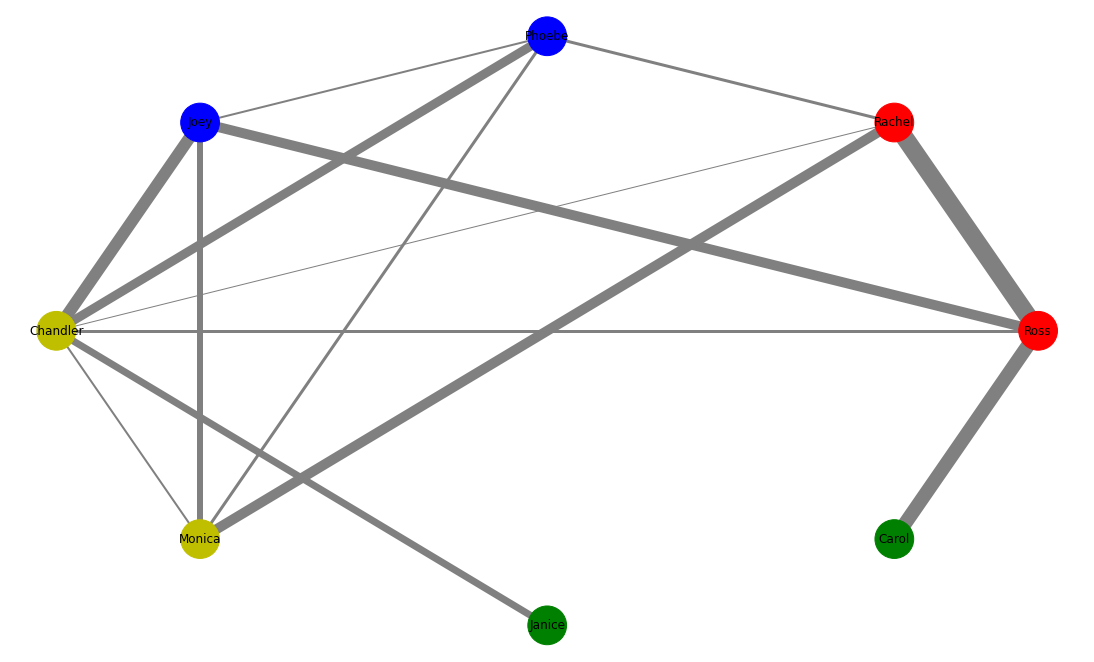

In [965]:
G = nx.Graph()
G.add_node("Ross", color='r')
G.add_node("Rachel", color='r')
G.add_node("Phoebe", color='b')
G.add_node("Joey", color='b')
G.add_node("Chandler", color='y')
G.add_node("Monica", color='y')
G.add_node("Janice", color='g')
G.add_node("Carol", color='g')

for i in range(len(conversation_weights)):
    G.add_edge(conversation_weights["A"][i],conversation_weights["B"][i], weight=round(conversation_weights["Conversation"][i]*100))

colors_nodes = nx.get_node_attributes(G,'color').values()
weights = nx.get_edge_attributes(G,'weight').values()
pos = nx.circular_layout(G)
nx.draw(G, pos, 
        edge_color="grey", 
        width=list(weights),
        with_labels=True,
        node_color= colors_nodes, node_size=1500)

## CountVectorizer (most spoken words by two people)

In [966]:
vectorizer = CountVectorizer(ngram_range =(3,3))

matrix = vectorizer.fit_transform(episode1_24["quote"])
matrix

<5594x20348 sparse matrix of type '<class 'numpy.int64'>'
	with 22855 stored elements in Compressed Sparse Row format>

In [967]:
y = episode1_24.iloc[:, 4].values

In [968]:
counts = pd.DataFrame(matrix.toarray(),index = list(y),
                      columns=vectorizer.get_feature_names())
counts = counts.groupby(counts.index).sum()

In [969]:
counts.T.columns

Index(['All', 'Chandler, Janice', 'Chandler, Joey', 'Chandler, Monica',
       'Chandler, Phoebe', 'Chandler, Rachel', 'Janice, Joey', 'Joey, Phoebe',
       'Monica & Rachel & Ross', 'Monica, Joey', 'Monica, Joey & Phoebe',
       'Monica, Rachel, Chandler, Joey', 'Phoebe, Monica', 'Phoebe, Rachel',
       'Rachel, Monica', 'Ross, Carol', 'Ross, Chandler', 'Ross, Joey',
       'Ross, Phoebe', 'Ross, Rachel', 'The boys', 'The girls'],
      dtype='object')

In [970]:
counts.T["Chandler, Janice"].sort_values(ascending = False).head(15)

looking im looking       2
to tell you              2
it stop it               2
im looking im            2
you can wear             2
tell you this            2
just my lens             2
its just my              2
stop it stop             2
for me to                2
me to tell               2
way for me               2
oh my god                2
brought you something    1
hello funny valentine    1
Name: Chandler, Janice, dtype: int64

## TfidfVectorizer (most spoken words by two people)

In [971]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(ngram_range =(3,3))

In [972]:
X = tfidf.fit_transform(episode1_24["quote"])
y = episode1_24.iloc[:, 4].values

In [973]:
counts2 = pd.DataFrame(X.toarray(),index = list(y),
                      columns=tfidf.get_feature_names())
counts2 = counts2.groupby(counts2.index).sum()

In [974]:
counts2.T["Chandler, Janice"].sort_values(ascending = False).head(15)

its just my              1.284457
just my lens             1.284457
thats right each         1.000000
how you doing            1.000000
hey its janice           1.000000
and yknow it             1.000000
oh no dont               1.000000
who invited who          1.000000
big screen tv            1.000000
are you ok               1.000000
you got it               1.000000
thats so sweet           1.000000
brought you something    1.000000
hello funny valentine    1.000000
whatever you want        1.000000
Name: Chandler, Janice, dtype: float64